# Model Diversity

In [1]:
import pickle
import re

import pandas as pd
import numpy as np
import plotly.express as px

# preprocessing
from sklearn.preprocessing import OneHotEncoder#, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# prep for models and search parameter space
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

# selection of features
from sklearn.decomposition import PCA

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
df = pd.read_csv('../data/clean/job_ads.csv')

In [4]:
df.head()

,title,department,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,job_ad,country
0,Marketing Intern,Marketing,0,1,0,Other,Internship,unknown,NaN,Marketing,0,"We're Food52, and we've created a groundbreaki...",US
1,Customer Service - Cloud Video Production,Success,0,1,0,Full-time,Not Applicable,unknown,Marketing and Advertising,Customer Service,0,"90 Seconds, the worlds Cloud Video Production ...",NZ
2,Commissioning Machinery Assistant (CMA),unknown,0,1,0,unknown,unknown,unknown,NaN,NaN,0,Valor Services provides Workforce Solutions th...,US
3,Account Executive - Washington DC,Sales,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,Our passion for improving quality of life thro...,US
4,Bill Review Manager,unknown,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,SpotSource Solutions LLC is a Global Human Cap...,US


## Transform Data

In [25]:
df.columns

Index(['title', 'department', 'telecommuting', 'has_company_logo',
       'has_questions', 'employment_type', 'required_experience',
       'required_education', 'industry', 'function', 'fraudulent', 'job_ad',
       'country'],
      dtype='object')

### `title`

In [26]:
df['title'].nunique()

11231

That's way too many to be helpful, going to __drop__ this column

### `department`

In [27]:
df['department'].nunique()

1338

Still too many to keep, __drop__ column.

### `employment_type`

In [28]:
df['employment_type'].nunique()

6

In [29]:
df['employment_type'].value_counts(normalize=True)

employment_type
Full-time    0.649888
unknown      0.194128
Contract     0.085235
Part-time    0.044575
Temporary    0.013479
Other        0.012696
Name: proportion, dtype: float64

Going to __one hot encode__ this column.

### `required_experience`

In [30]:
df['required_experience'].nunique()

8

In [31]:
df['required_experience'].value_counts(normalize=True)

required_experience
unknown             0.394295
Mid-Senior level    0.213031
Entry level         0.150839
Associate           0.128468
Not Applicable      0.062416
Director            0.021756
Internship          0.021309
Executive           0.007886
Name: proportion, dtype: float64

Going to __one hot encode__ this column

### `required_education`

In [32]:
df['required_education'].nunique()

14

In [34]:
df['required_education'].value_counts(normalize=True)

required_education
unknown                              0.453300
Bachelor's Degree                    0.287752
High School or equivalent            0.116331
Unspecified                          0.078132
Master's Degree                      0.023266
Associate Degree                     0.015324
Certification                        0.009508
Some College Coursework Completed    0.005705
Professional                         0.004139
Vocational                           0.002740
Some High School Coursework          0.001510
Doctorate                            0.001454
Vocational - HS Diploma              0.000503
Vocational - Degree                  0.000336
Name: proportion, dtype: float64

Going to __drop__ for now (especially since 45% are unknown).  Otherwise, I could divide this into a few combinations: such as complete high school, completed some college, bachelors, and graduate degree.  But there are lots of uncertain and gray areas: professional degrees, vocational degrees, and certification could all be in additional to a college degree or an alternate / preferred path for the field.

### `industry`

In [35]:
df['industry'].nunique()

131

Too big, __drop__ this column.

### `function`

In [36]:
df['function'].nunique()

37

In [37]:
df['function'].value_counts(normalize=True)

function
Information Technology    0.153085
Sales                     0.128490
Engineering               0.117987
Customer Service          0.107571
Marketing                 0.072648
Administrative            0.055142
Design                    0.029759
Health Care Provider      0.029584
Other                     0.028446
Education                 0.028446
Management                0.027746
Business Development      0.019956
Accounting/Auditing       0.018556
Human Resources           0.017943
Project Management        0.016018
Finance                   0.015055
Consulting                0.012604
Writing/Editing           0.011554
Art/Creative              0.011554
Production                0.010153
Product Management        0.009978
Quality Assurance         0.009716
Advertising               0.007877
Business Analyst          0.007352
Data Analyst              0.007177
Public Relations          0.006652
Manufacturing             0.006477
General Business          0.005952
Research   

This column also has too many unique values to keep, however, this is another one that could benefit from some detailed investigation.  __Drop__ column for now.

### `country`

In [38]:
df['country'].nunique()

90

Going to __drop__ this column as well.  A more interesting piece of information is if the company is advertising inside or outside of their easy-to-hire region.

### Summary of Columns

| Column | Data Type | Plans |
| --- | --- | --- |
| `title` | categorical | drop |
| `department` | categorical | drop |
| `telecommuting` | boolean | keep as is |
| `has_company_logo` | boolean | keep as is |
| `has_questions` | boolean | keep as is |
| `employment_type` | categorical | one hot encode |
| `required_experience` | categorical | one hot encode |
| `required_education` | categorical | drop | 
| `industry` | categorical | drop |
| `function` | categorical | drop |
| `job_ad` | text | process |
| `country` | categorical | drop |

_Note:_ a company logo's can be easily made up or stolen, so this may or may not be a helpful piece of information

## Set Up Data

In [39]:
X = df.drop(columns=['fraudulent', 'title', 'department', 'required_education', 'industry', 'function', 'country'])
y = df['fraudulent']

In [48]:
X = X.fillna('')

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [50]:
X_train.columns

Index(['telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'job_ad'],
      dtype='object')

## Model 1: Basic Logistic Regression, no penalty, with CountVectorizer

In [53]:
model_log = Pipeline([
    ('ct', ColumnTransformer([
        ('cvec', CountVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('log', LogisticRegression(penalty=None))
])

In [54]:
model_log.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cvec',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('log', LogisticRegression(penalty=None))])

In [69]:
def evaluate_model(model, X_test, y_test, save_figs = False, fig_subtitle = 'Model', short_name='log'):
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)
    fig_cm = ConfusionMatrixDisplay.from_predictions(y_test, preds, display_labels=['real','fraudulent']);
    fig_cm.figure_
    print(f"\nClassification Report: \n")
    print(classification_report(y_test, preds, target_names=['real', 'fraudulent']))
    results = []
    for i in range(len(y_test)):
        if preds[i] != y_test.iloc[i]:
            results.append({'actual': y_test.iloc[i], 'predicted': preds[i], 'prob_fraud': proba[i][1]})

    res = pd.DataFrame(results)

    fig_hist = px.histogram(res, x='prob_fraud', title = 'Probability Distribution of Misclassified Job Ads', subtitle=fig_subtitle)

    fig_hist.show()

    if save_figs == True:
        fig_cm.figure_.save_fig(f'../images/cm_{short_name}.png')
        fig_hist.write_image(f'../images/hist_{short_name}.png')

    return res


Classification Report: 

              precision    recall  f1-score   support

        real       0.99      1.00      0.99      4254
  fraudulent       0.88      0.74      0.81       216

    accuracy                           0.98      4470
   macro avg       0.94      0.87      0.90      4470
weighted avg       0.98      0.98      0.98      4470



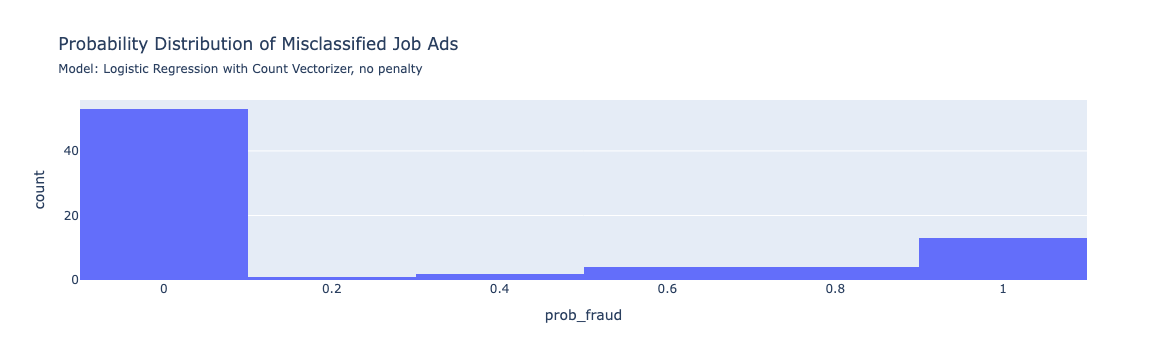

,actual,predicted,prob_fraud
0,1,0,1.163141e-30
1,1,0,3.487529e-02
2,1,0,1.685445e-02
3,1,0,6.244944e-10
4,1,0,1.872535e-17
...,...,...,...
72,0,1,5.628221e-01
73,0,1,9.284695e-01
74,1,0,3.432791e-02
75,1,0,3.162422e-01


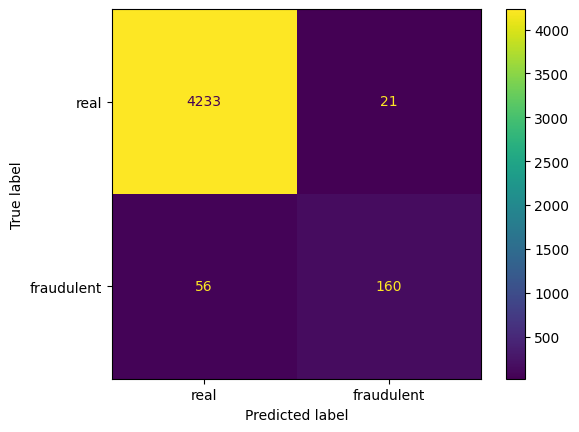

In [70]:
evaluate_model(model_log, X_test, y_test, fig_subtitle= 'Model: Logistic Regression with Count Vectorizer, no penalty', short_name='log')

## Model 1B: Logistic Regression with TF-IDF Vectorizer

In [ ]:
model_log_tfidf = Pipeline([
    ('ct', ColumnTransformer([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('log', LogisticRegression(penalty=None))
])

In [ ]:
model_log_tfidf.fit(X_train, y_train)

In [ ]:
evaluate_model(model_log_tfidf, X_test, y_test, fig_subtitle= 'Model: Logistic Regression with TF-IDF Vectorizer, no penalty', short_name='log_tfidf')

## Model 2: Logistic Regression, no penalty, with Count Vectorizer, add PCA

In [72]:
model_log_pca = Pipeline([
    ('ct', ColumnTransformer([
        ('cvec', CountVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA()),
    ('log', LogisticRegression(penalty=None))
])

In [ ]:
model_log_pca.fit(X_train, y_train)

In [ ]:
evaluate_model(model_log_pca, X_test, y_test, fig_subtitle= 'Model: Logistic Regression, no penalty, with Count Vectorizer and PCA', short_name='log')

## Model 2B: Logistic Regression, no penalty, with TF-IDF Vectorizer, add PCA

In [ ]:
model_log_tfidf_pca = Pipeline([
    ('ct', ColumnTransformer([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA()),
    ('log', LogisticRegression(penalty=None))
])

In [ ]:
model_log_tfidf_pca.fit(X_train, y_train)

In [ ]:
evaluate_model(model_log_tfidf_pca, X_test, y_test, fig_subtitle= 'Model: Logistic Regression, no penalty, with TF-IDF Vectorizer and PCA', short_name='log_tfidf_pca')

## Models 3: Logistic Regression with Regularization

In [ ]:
model_log_reg_pca = Pipeline([
    ('ct', ColumnTransformer([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA()),
    ('log', LogisticRegression())
])

In [ ]:
log_reg_pca_params = {
    'pca__n_components': [100, 500, 1000],
    'log__penalty': ['l1', 'l2'],
    'log__C': [1, 0.5, 0.1, 0.01]
}

In [ ]:
gs_log_pca = GridSearchCV(model_log_reg_pca, param_grid= log_reg_pca_params, scoring='f1', njobs=-1)

In [ ]:
gs_log_pca.fit(X_train, y_train)

In [ ]:
gs_log_pca.best_score_
gs_log_pca.best_params_